In [26]:
import pandas as pd
import numpy as np

In [27]:
# load the penguins dataset
url = "https://raw.githubusercontent.com/roualdes/data/refs/heads/master/penguins.csv"
penguins = pd.read_csv(url)

In [28]:
# Select numerical columns for clustering
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
penguins = penguins[features].dropna()

In [29]:
# Normalize the data to improve clustering
penguins_norm = (penguins - penguins.mean()) / penguins.std()

In [30]:
# Convert to Numpy array fo Stan
data_array = penguins_norm.to_numpy()

In [31]:
N, D = data_array.shape
K = 3 # number of clusters

# Stan code for soft K-means clustering
stan_data = {
    "N": N,
    "D": D,
    "K": K,
    "y": data_array.tolist()
}

In [32]:
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /Users/adrianvalen27/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


True

In [ ]:
from cmdstanpy import CmdStanModel

# Compile the Stan model
model = CmdStanModel(stan_file="soft_kmeans.stan")

# Fit the model to the data
fit = model.sample(data=stan_data, chains=4, parallel_chains=4, iter_sampling=1000, iter_warmup=500)

05:27:12 - cmdstanpy - INFO - compiling stan file /Users/adrianvalen27/Desktop/CSCI385/final/soft_kmeans.stan to exe file /Users/adrianvalen27/Desktop/CSCI385/final/soft_kmeans
05:27:17 - cmdstanpy - INFO - compiled model executable: /Users/adrianvalen27/Desktop/CSCI385/final/soft_kmeans
05:27:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

05:27:21 - cmdstanpy - INFO - CmdStan done processing.


In [ ]:
# Extract the soft assignments (soft_z)
soft_z_samples = fit.stan_variable("soft_z")  # Shape: (num_samples, N, K)

# Average over all posterior samples
soft_z_mean = np.mean(soft_z_samples, axis=0)  # Shape: (N, K)

# Assign each data point to the cluster with the highest mean log probability
assignments = np.argmax(soft_z_mean, axis=1)

# Add cluster labels back to the original data
penguins["cluster"] = assignments

# Display the first few rows of the data with cluster labels
print(penguins.head())
print("Soft_z_samples shape:", soft_z_samples.shape)
print("Soft_z_mean shape:", soft_z_mean.shape)
print("Assignments shape:", assignments.shape)
print("Penguins shape:", penguins.shape)

   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  cluster
0            39.1           18.7              181.0       3750.0        0
1            39.5           17.4              186.0       3800.0        0
2            40.3           18.0              195.0       3250.0        0
4            36.7           19.3              193.0       3450.0        0
5            39.3           20.6              190.0       3650.0        0
Soft_z_samples shape: (4000, 342, 3)
Soft_z_mean shape: (342, 3)
Assignments shape: (342,)
Penguins shape: (342, 5)


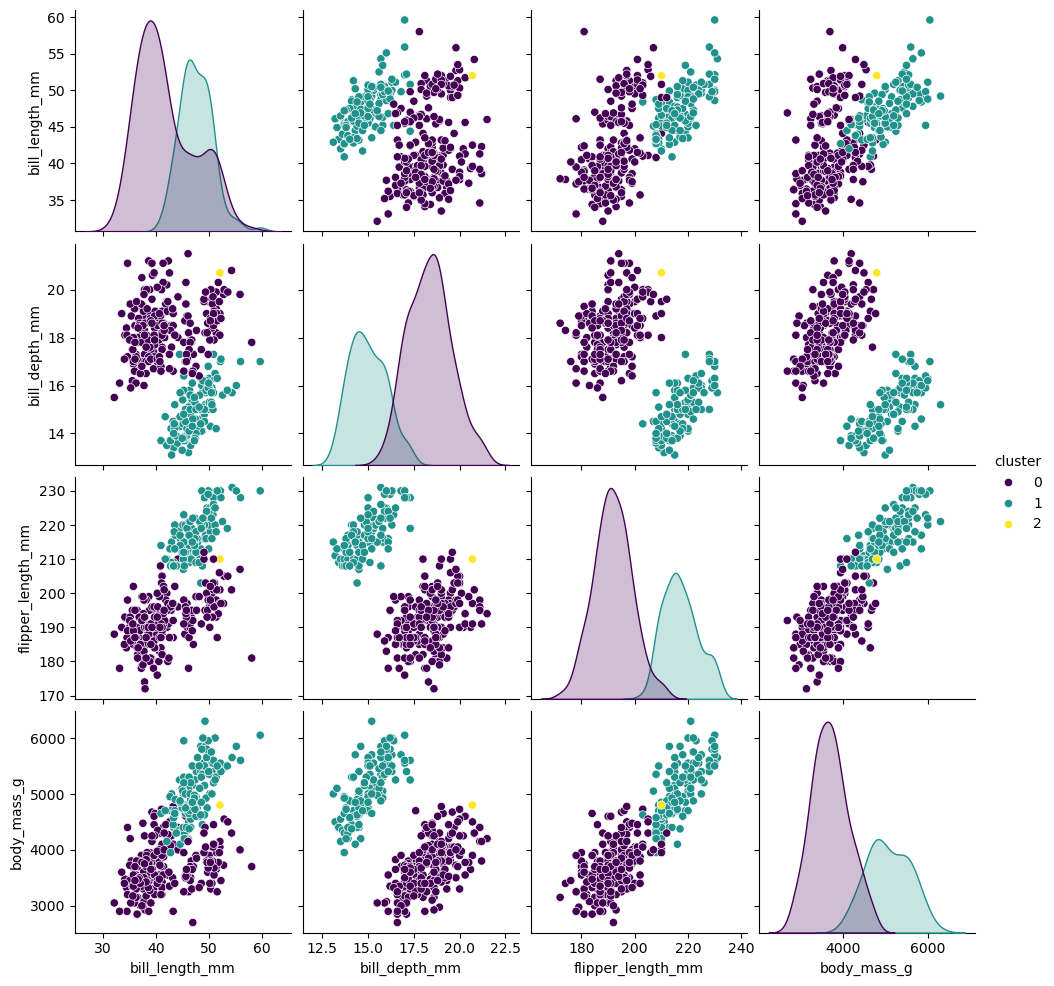

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(penguins, hue="cluster", palette="viridis")
plt.show()

# Overview

This plot illustrates the relationship between four numerical features of penguins:
* Bill length (mm)
* Bill depth (mm)
* Flipper length (mm)
* Body mass (g)

Where each point represents an individual penguin, and the color indicates the assigned cluster (Cluster 0, 1, or 2)

# What are we looking at!?

### 1.) Diagonal Plots (Histograms):
- The diagonal contains distributions for each feature across all penguins
- The separation in the distributions suggests that different clusters have distinct ranges for some features (flipper length and body mass)

### 2.) Off-Diagonal Scatter Plots:
- The off-diagonal cells are scatter plots of every possible pair of features
- These scatter plots allow us to see how clusters are distributed when comparing two features at a time

### 3.) Clusters:
- The three colors (purple, gray, and yellow) represent the clusters assigned by the soft K-means algorithm.
- Each cluster likely corresponds to a group of penguins with similar physical characteristics.

# Key Observations!

### 1.) Cluster Separation:
- There is a clear separation between clusters in some feature combinations, like "Bill Length vs. Flipper Length"
- However, some overlap exists in other feature pairings, like "Bill Depth vs Flipper Length"

### 2.) Feature Importance:
- Features like flipper length and body mass appear to strongly differentiate the clusters, as evident from their well-separated distributions.

### 3.) Real-World Meaning:
- These clusters might correspond to different species of penguins in the dataset. The algorithm has grouped penguins based on their shared physical characteristics, though it doesn't inherently know species labels.

# Conclusion

All this to say, this plot demonstrates how clustering can uncover hidden patterns in data. The identified clusters might represent distinct groups of penguins with shared traits.

Such clustering can help scientists or conservationists quickly identify species, study habitat preferences, or monitor populations based on physical attributes.